<a href="https://colab.research.google.com/github/alik604/mathematical-finance/blob/master/XEG_ETF_decompotion_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XEG
https://www.blackrock.com/ca/investors/en/products/239839/ishares-sptsx-capped-energy-index-etf

### This notebook does not include good predictions. For that refer to code for an LSTM [here](https://github.com/alik604/mathematical-finance)

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
!pip install pandas-datareader
from pandas_datareader import data as pdr
!pip install fix-yahoo-finance
import fix_yahoo_finance as yf


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas_datareader.data as web
import datetime
 
  
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

plt.style.use('fivethirtyeight')  
  
  
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
start = datetime.datetime(2020,3,21)
end = datetime.date.today()

Populating the interactive namespace from numpy and matplotlib


# Note
I consider only the top 10 and the ETF itself. Then I ignore the holdings that are <3%, but add `XOM` and `CVX`   
## Let's plot them

In [2]:

symbols = ['XEG.to', 'SU.to','CNQ.to','CVE.to','TOU.to','IMO.to'] # ,'PXT.to','CPG.to','PSK.to','ARX.to','WCP.to'
tmp = {
                      symbols[0]: web.DataReader(symbols[0], "yahoo", start, end)["Adj Close"], # XEG
                      symbols[1]: web.DataReader(symbols[1], "yahoo", start, end)["Adj Close"],
                      symbols[2]: web.DataReader(symbols[2], "yahoo", start, end)["Adj Close"],
                      symbols[3]: web.DataReader(symbols[3], "yahoo", start, end)["Adj Close"],
                      symbols[4]: web.DataReader(symbols[4], "yahoo", start, end)["Adj Close"],
                      symbols[5]: web.DataReader(symbols[5], "yahoo", start, end)["Adj Close"],
                      # symbols[6]: web.DataReader(symbols[6], "yahoo", start, end)["Adj Close"],
                      # symbols[7]: web.DataReader(symbols[7], "yahoo", start, end)["Adj Close"],
                      # symbols[8]: web.DataReader(symbols[8], "yahoo", start, end)["Adj Close"],
                      # symbols[9]: web.DataReader(symbols[9], "yahoo", start, end)["Adj Close"],
                      # symbols[10]:web.DataReader(symbols[10],"yahoo", start, end)["Adj Close"], 
                      "XOM": web.DataReader("XOM", "yahoo", start, end)["Adj Close"],
                      "CVX": web.DataReader("CVX", "yahoo", start, end)["Adj Close"],
}

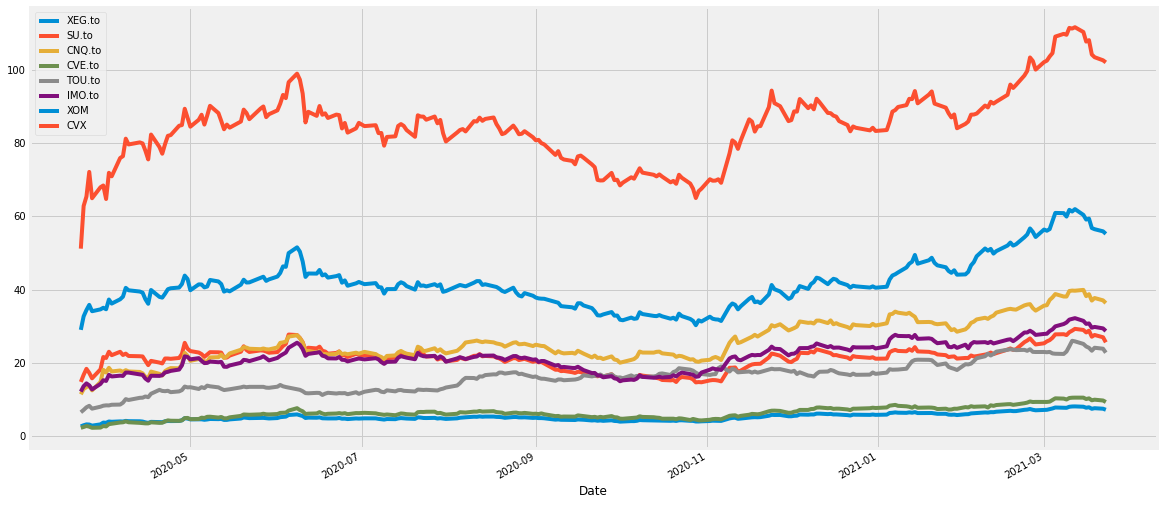

In [3]:
# AAPL = web.DataReader("AAPL", "yahoo", start, end)
# NFLX = web.DataReader("NFLX", "yahoo", start, end)
# GOOG = web.DataReader("GOOG", "yahoo", start, end)
# FB   = web.DataReader("FB", "yahoo", start, end)
# AMZN = web.DataReader("AMZN", "yahoo", start, end)
# BABA = web.DataReader("BABA", "yahoo", start, end)
# BIDU = web.DataReader("BIDU", "yahoo", start, end)
# NVDA = web.DataReader("NVDA", "yahoo", start, end)
# TSLA = web.DataReader("TSLA", "yahoo", start, end)
# TWTR = web.DataReader("TWTR", "yahoo", start, end)

# FNGU = web.DataReader("FNGU", "yahoo", start, end)

# MSFT = web.DataReader("MSFT", "yahoo", start, end)


stocks = pd.DataFrame(tmp)
stocks=stocks.dropna()
stocks.plot(grid=True, figsize=(18,9))

In [4]:
print(f'From {str(stocks.index[0].date())} to {str(stocks.index[-1].date())}')

From 2020-03-23 to 2021-03-23


## let's do stuff to feel smart...

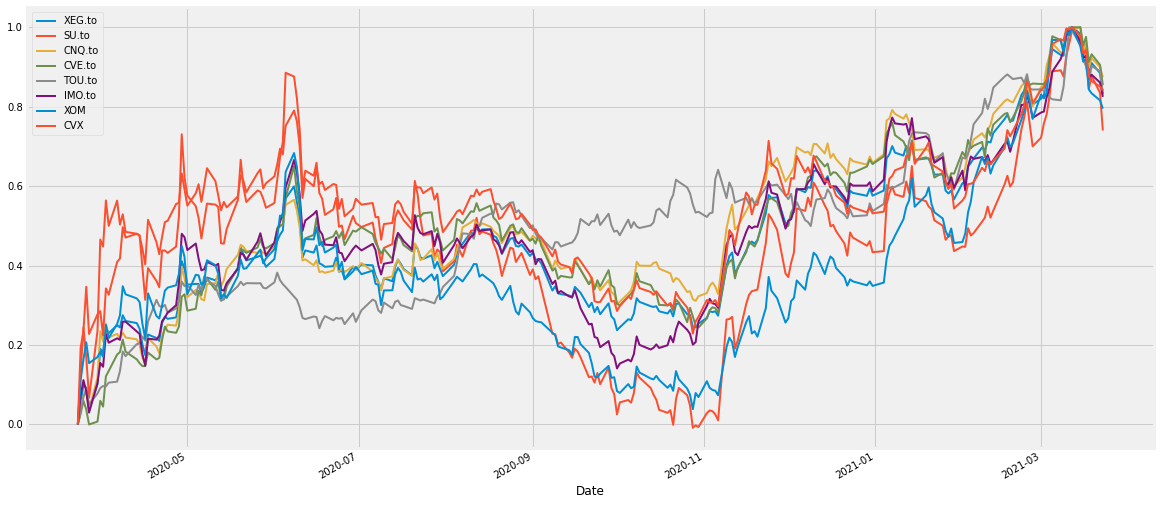

In [5]:
def normIt(myDf):
   return (myDf - myDf.mean()) / (myDf.max() - myDf.min())

stocks_norm = normIt(stocks)
stocks_norm = stocks_norm.dropna()
# for i in stocks_norm:
#   tmp = stocks_norm.loc[:, i]
#   offset = 0 - tmp[0]
#   stocks_norm.loc[:, i] += offset

stocks_norm -= stocks_norm.iloc[0]
stocks_norm.plot(grid=True, linewidth=2, figsize=(18, 9))

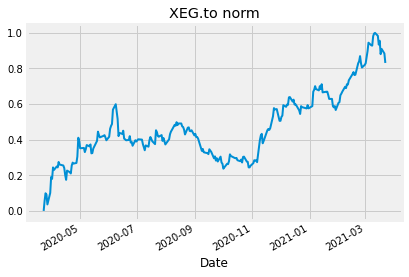

In [6]:
stocks_norm['XEG.to'].plot(grid=True, linewidth=2, title = "XEG.to norm")

In [8]:
stocks_norm.head(1) # yup all zeros

,XEG.to,SU.to,CNQ.to,CVE.to,TOU.to,IMO.to,XOM,CVX
Date,,,,,,,,
2020-03-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Correlations 

In [9]:
corrwith = stocks_norm.corr()
corrwith

,XEG.to,SU.to,CNQ.to,CVE.to,TOU.to,IMO.to,XOM,CVX
XEG.to,1.000000,0.748430,0.980226,0.978175,0.813663,0.975052,0.890618,0.892796
SU.to,0.748430,1.000000,0.631431,0.693399,0.272407,0.804027,0.900789,0.915461
CNQ.to,0.980226,0.631431,1.000000,0.965274,0.864335,0.941683,0.792941,0.816017
CVE.to,0.978175,0.693399,0.965274,1.000000,0.797192,0.956777,0.846331,0.859197
TOU.to,0.813663,0.272407,0.864335,0.797192,1.000000,0.715251,0.568418,0.554468
IMO.to,0.975052,0.804027,0.941683,0.956777,0.715251,1.000000,0.893030,0.921289
XOM,0.890618,0.900789,0.792941,0.846331,0.568418,0.893030,1.000000,0.941656
CVX,0.892796,0.915461,0.816017,0.859197,0.554468,0.921289,0.941656,1.000000


In [10]:
from scipy.stats import spearmanr

corrwith_spearman = spearmanr(stocks_norm)[0]
corrwith_spearman = pd.DataFrame(corrwith_spearman, index=stocks.columns, columns=stocks.columns)
corrwith_spearman

,XEG.to,SU.to,CNQ.to,CVE.to,TOU.to,IMO.to,XOM,CVX
XEG.to,1.000000,0.685713,0.973790,0.974577,0.709402,0.976343,0.818815,0.866824
SU.to,0.685713,1.000000,0.575450,0.648384,0.174533,0.738609,0.905203,0.885863
CNQ.to,0.973790,0.575450,1.000000,0.948271,0.775182,0.930856,0.713828,0.787784
CVE.to,0.974577,0.648384,0.948271,1.000000,0.668375,0.948995,0.806552,0.824688
TOU.to,0.709402,0.174533,0.775182,0.668375,1.000000,0.647260,0.352264,0.451327
IMO.to,0.976343,0.738609,0.930856,0.948995,0.647260,1.000000,0.853125,0.891041
XOM,0.818815,0.905203,0.713828,0.806552,0.352264,0.853125,1.000000,0.925089
CVX,0.866824,0.885863,0.787784,0.824688,0.451327,0.891041,0.925089,1.000000


In [11]:
# corr_cumSum = corrwith.cumsum()
corr_cumSum = corrwith_spearman.cumsum()
corr_cumSum

,XEG.to,SU.to,CNQ.to,CVE.to,TOU.to,IMO.to,XOM,CVX
XEG.to,1.000000,0.685713,0.973790,0.974577,0.709402,0.976343,0.818815,0.866824
SU.to,1.685713,1.685713,1.549240,1.622961,0.883935,1.714951,1.724018,1.752687
CNQ.to,2.659504,2.261164,2.549240,2.571232,1.659117,2.645807,2.437846,2.540471
CVE.to,3.634081,2.909548,3.497511,3.571232,2.327492,3.594802,3.244399,3.365159
TOU.to,4.343483,3.084081,4.272693,4.239607,3.327492,4.242063,3.596662,3.816486
IMO.to,5.319826,3.822689,5.203550,5.188602,3.974753,5.242063,4.449788,4.707527
XOM,6.138640,4.727892,5.917378,5.995154,4.327016,6.095188,5.449788,5.632617
CVX,7.005464,5.613755,6.705162,6.819842,4.778343,6.986229,6.374877,6.632617


In [12]:
keepThese = corr_cumSum.loc[:, corr_cumSum.iloc[-1] > corr_cumSum.iloc[-1].mean()*1.01]
keepThese

,XEG.to,CNQ.to,CVE.to,IMO.to,CVX
XEG.to,1.000000,0.973790,0.974577,0.976343,0.866824
SU.to,1.685713,1.549240,1.622961,1.714951,1.752687
CNQ.to,2.659504,2.549240,2.571232,2.645807,2.540471
CVE.to,3.634081,3.497511,3.571232,3.594802,3.365159
TOU.to,4.343483,4.272693,4.239607,4.242063,3.816486
IMO.to,5.319826,5.203550,5.188602,5.242063,4.707527
XOM,6.138640,5.917378,5.995154,6.095188,5.632617
CVX,7.005464,6.705162,6.819842,6.986229,6.632617


In [13]:
# keepThese = keepThese.loc[:, keepThese.iloc[-1] > keepThese.iloc[-1].mean()]
# keepThese

In [14]:
dropAllButThese = keepThese.columns.to_list()
corrwith[dropAllButThese]#.cumsum()

,XEG.to,CNQ.to,CVE.to,IMO.to,CVX
XEG.to,1.000000,0.980226,0.978175,0.975052,0.892796
SU.to,0.748430,0.631431,0.693399,0.804027,0.915461
CNQ.to,0.980226,1.000000,0.965274,0.941683,0.816017
CVE.to,0.978175,0.965274,1.000000,0.956777,0.859197
TOU.to,0.813663,0.864335,0.797192,0.715251,0.554468
IMO.to,0.975052,0.941683,0.956777,1.000000,0.921289
XOM,0.890618,0.792941,0.846331,0.893030,0.941656
CVX,0.892796,0.816017,0.859197,0.921289,1.000000


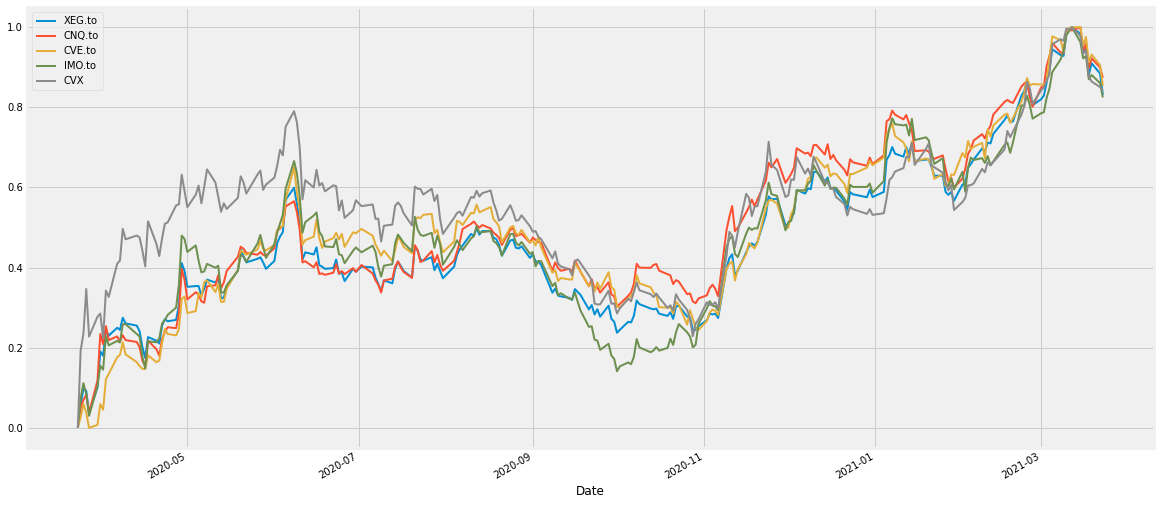

In [15]:
stocks_main_norm = stocks_norm[dropAllButThese]
stocks_main_norm.plot(grid=True, linewidth=2, figsize=(18, 9))

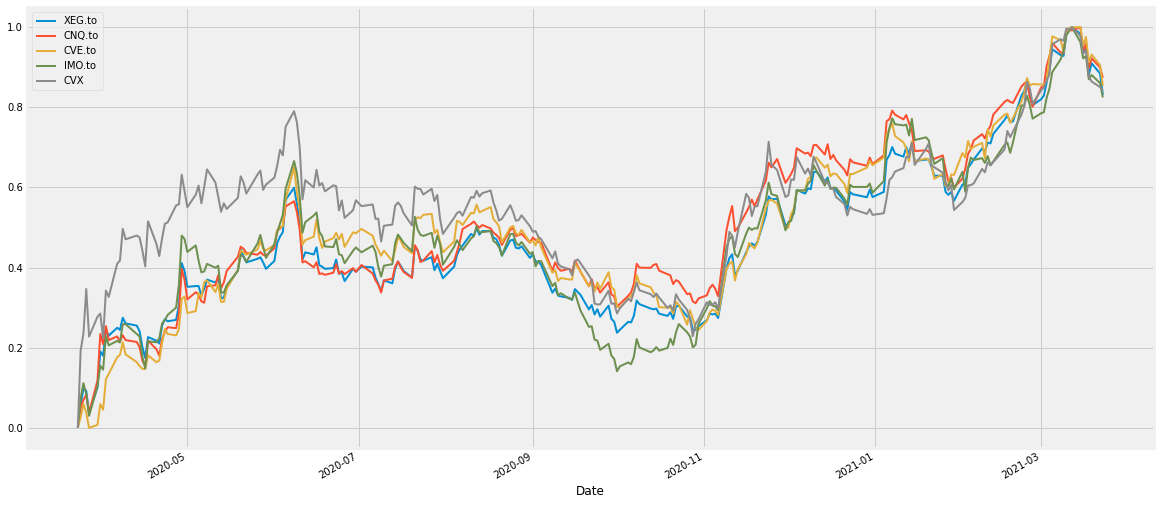

#  Better Prediction
(compared to end of notebook)

.. better to use a LTSM, this still sucks. maybe one day I'll fix this, or perhaps till will be fixed but in another notebook. Who knows 

In [18]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import BayesianRidge

from fbprophet import Prophet
from sklearn.svm import SVR 
import xgboost

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



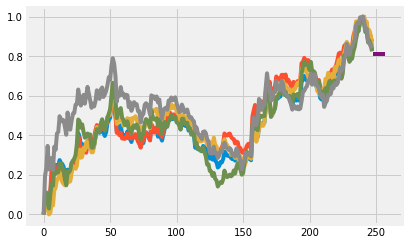

In [19]:
df = stocks_main_norm
x = np.arange(df.shape[0]).reshape(-1, 1)
x_pred = np.arange(df.shape[0], df.shape[0]+10).reshape(-1, 1)
y = df.values # ["XEG.to"]

xg_reg = xgboost.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.05,
                max_depth = 50, alpha = 10, n_estimators = 50)

_ = xg_reg.fit(x,y)
y_pred = xg_reg.predict(x_pred)

plt.plot(x, y)
plt.plot(x_pred, y_pred)

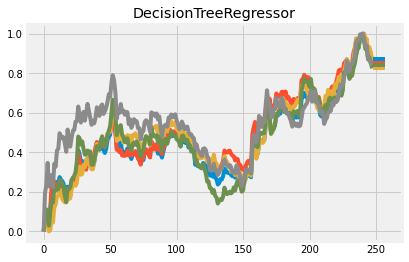

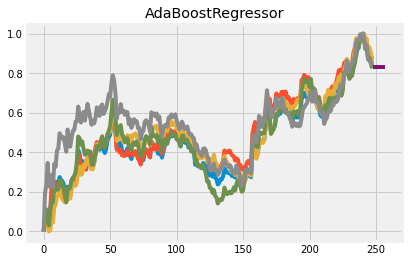

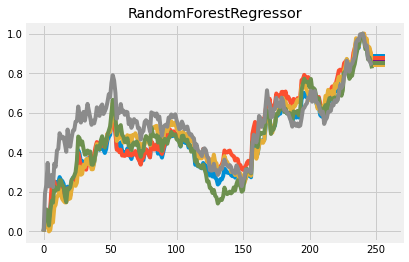

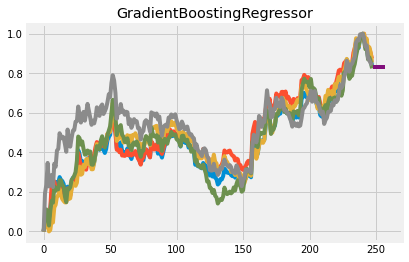

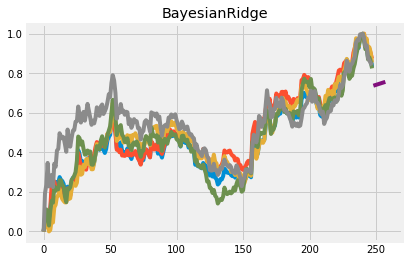

In [21]:
regs = [DecisionTreeRegressor(),
        AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), loss='square'),
        RandomForestRegressor(200),
        GradientBoostingRegressor(n_estimators=150, max_depth=5),
        BayesianRidge(n_iter=500, tol=0.0015, normalize=True)]
for reg in regs:
  try:
    _ = reg.fit(x, y)
  except:
    _ = reg.fit(x, stocks_main_norm["XEG.to"].values)

  
  y_pred = reg.predict(x_pred)

  _ = plt.plot(x, y)
  _ = plt.plot(x_pred, y_pred)
  _ = plt.title(str(type(reg)).split(".")[-1][:-2])
  plt.show()

In [22]:
# svr_rbf = SVR(kernel='rbf')
# svr_rbf.fit(x, y)

# plt.scatter(dates, prices, c='k', label='Data')
# plt.plot(dates, svr_lin.predict(dates), c='g', label='Linear model')
# plt.plot(dates, svr_rbf.predict(dates), c='r', label='RBF model')    
# plt.plot(dates, svr_poly.predict(dates), c='b', label='Polynomial model')

# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Support Vector Regression')
# plt.legend()
# plt.show()

# Prediction



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



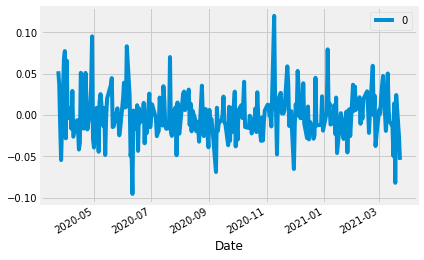

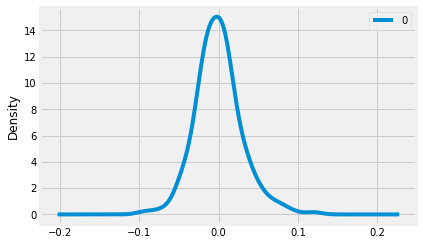

                0
count  247.000000
mean    -0.000028
std      0.029392
min     -0.095312
25%     -0.017699
50%     -0.001375
75%      0.014123
max      0.119891


In [23]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
  

model = ARIMA(quickDF["XEG.to"], order=(5,1,0))
model_fit = model.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

predicted=0.772353, expected=0.779728
predicted=0.783519, expected=0.763207
predicted=0.762109, expected=0.765043
predicted=0.769900, expected=0.829289
predicted=0.840837, expected=0.840302
predicted=0.844122, expected=0.869672
predicted=0.866845, expected=0.829289
predicted=0.830006, expected=0.805426
predicted=0.812986, expected=0.820111
predicted=0.829642, expected=0.829289
predicted=0.839145, expected=0.862330
predicted=0.860927, expected=0.897206
predicted=0.898096, expected=0.944932
predicted=0.949276, expected=0.930247
predicted=0.929762, expected=0.928411
predicted=0.930474, expected=0.981644
predicted=0.993222, expected=0.996329
predicted=1.006029, expected=1.000000
predicted=0.997374, expected=0.983480
predicted=0.984554, expected=0.933918
predicted=0.940936, expected=0.955945
predicted=0.965103, expected=0.880686
predicted=0.886198, expected=0.910055
predicted=0.911165, expected=0.884357
predicted=0.888524, expected=0.831124
Test MSE: 0.00114


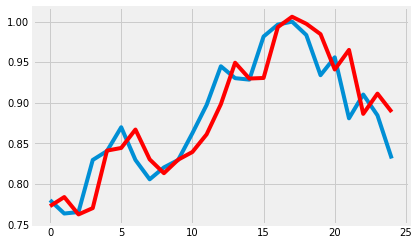

In [24]:
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

X = quickDF["XEG.to"].values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test+10)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.5f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# ARIMA to forecast 

predicted=0.777541, expected=0.779728
predicted=0.812236, expected=0.763207
predicted=0.786651, expected=0.765043
predicted=0.753238, expected=0.829289
predicted=0.842125, expected=0.840302
predicted=0.855261, expected=0.869672
predicted=0.876575, expected=0.829289
predicted=0.838420, expected=0.805426


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.854742, expected=0.820111


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



predicted=0.871877, expected=0.829289
predicted=0.879719, expected=0.862330
predicted=0.858067, expected=0.897206
predicted=0.898393, expected=0.944932
predicted=0.950008, expected=0.930247
predicted=0.925444, expected=0.928411
predicted=0.926038, expected=0.981644
predicted=0.994678, expected=0.996329
predicted=1.009101, expected=1.000000
predicted=1.008113, expected=0.983480
predicted=0.994409, expected=0.933918
predicted=0.953610, expected=0.955945
predicted=0.992495, expected=0.880686
predicted=0.895537, expected=0.910055
predicted=0.909874, expected=0.884357
predicted=0.891755, expected=0.831124
predicted=0.852191, expected=0.852191


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



predicted=0.807825, expected=0.807825
predicted=0.829862, expected=0.829862
predicted=0.826688, expected=0.826688
predicted=0.806789, expected=0.806789
predicted=0.823493, expected=0.823493
predicted=0.799219, expected=0.799219
predicted=0.811865, expected=0.811865
predicted=0.810366, expected=0.810366
predicted=0.800628, expected=0.800628


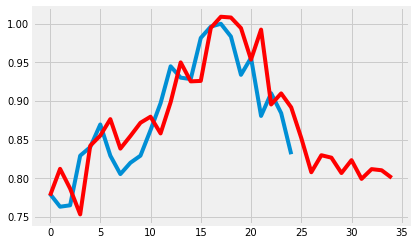

In [25]:
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

X = quickDF["XEG.to"].values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
#print (history==train) #True 
for t in range(len(test)+10):
    model = ARIMA(history[-1*len(test):], order=(5,1,0)) # changed*
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    try:
      obs = test[t]
    except IndexError:
      obs = yhat
	

    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
 
# error = mean_squared_error(test, predictions)
# print('Test MSE: %.5f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [26]:
import numpy as np

#stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change = stocks.apply(lambda x: (x) - (x.shift(1))) # shift moves dates back by 1.
stock_change=stock_change.dropna()
stock_change.head()

,XEG.to,SU.to,CNQ.to,CVE.to,TOU.to,IMO.to,XOM,CVX
Date,,,,,,,,
2020-03-24,0.306774,1.937005,1.433079,0.219625,0.639240,1.473161,3.685371,11.640667
2020-03-25,0.233466,1.628624,0.546833,0.269540,0.716723,0.760653,1.708763,2.567921
2020-03-26,-0.039074,-1.098600,0.358269,-0.179693,0.406790,-0.548826,1.413185,6.712494
2020-03-27,-0.302823,-1.484072,-1.253944,-0.309472,-0.774837,-1.088019,-1.727230,-7.175102
2020-03-30,0.351665,2.447756,2.262757,0.059898,0.532701,1.492416,0.508015,2.992775


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c18d47e50>,
      dtype=object)

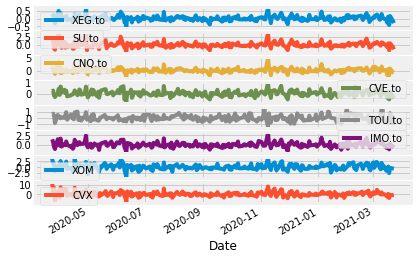

In [27]:
stock_change.plot(grid = True,subplots=True)#.axhline(y = 0, color = "black", lw = 2)

In [28]:
!pip install https://github.com/matplotlib/mpl_finance/archive/master.zip


  Using cached https://github.com/matplotlib/mpl_finance/archive/master.zip
  Created wheel for mpl-finance: filename=mpl_finance-0.10.1-cp37-none-any.whl size=8424 sha256=5ccea92df7567e4653e78a0d526c928ed6ca85b2fe30c9d3aa06517b1ebfc279
  Stored in directory: /tmp/pip-ephem-wheel-cache-jg2k3bk7/wheels/8f/bf/8a/6c858b2a3be945c7b2d658fbf6ab797b451d686cbee8aa2679
Successfully built mpl-finance


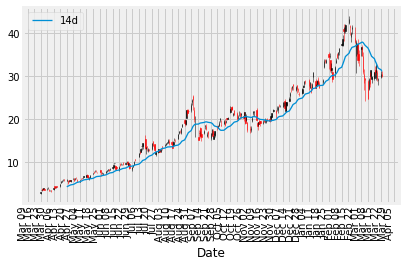

In [29]:
from matplotlib.dates import DateFormatter, WeekdayLocator,    DayLocator, MONDAY
from mpl_finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
 
    plt.show()
 
#pandas_candlestick_ohlc(apple)
FNGU = web.DataReader("FNGU", "yahoo", start, end)

FNGU["14d"] = np.round(FNGU["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(FNGU.loc['2019-01-04':], otherseries = "14d") # FNGU.loc['201-01-04':'2016-08-07',:]

does the PCA of the lesser CORR fetures assist in forcasting an index? 